# Parameter estimation for models of cell motility

<strong>Summary</strong>

<div style="text-align: justify"> 
Parameter recovery studies of active cell motion in the CPM using the FitMultiCell pipeline have not provided a satisfying aproximation of the real posterior distributions using the time-averaged mean-squared-displacement (TAMSD) and the direction-autocorrelation function (DAC) as the summary statistics (SS) functions. In order to tackle and solve this problem, new functions summarizing information about particles' trajectories in space are introduced and their applicability as SS functions is studied by using different combinations of them in the FitMultiCell pipeline and observing their performance for different percentages of microscopic time steps (1%, 10%, and 100%). It is found that the pipeline's performance increases with some of the newly introduced functions and with higher time-step percentages. 
</div>

<strong>Introduction</strong>

<div style="text-align: justify"> 
There is a major question on which modes cells use for migrating and how this process is controlled under different biophysical conditions. Mathematical and computational models can provide insights into these kind of mechanisms and can also help to validate experimental results and provide a broader scope on how some processes depend on specific parameters. During the last decades, quantities such as the mean-squared displacement (MSD) and the velocity autocorrelation function (VAC) have been extensively used to identify the type of motion a cell performs and how persistent it is. In <a href="https://www.nature.com/articles/nprot.2014.131"> Gorelik 2014</a>, a comprehensive protocol explains in detail the advantages of both this functions. However, some studies have also pointed out the limitations of the MSD and VAC functions like in <a href="https://link.springer.com/article/10.1007%2Fs00397-013-0694-6">Gal et al. 2013</a>. In short terms, this failure may be attributed to the wide spread of values on the calculation of both functions for individual random processes (more noticeable in the VAC) and due to averaging and oversimplification errors.

As a response, several approaches have been suggested for singles-particle trajectory analysis, where both directionality and displacement are the main focus of the analysis. A popular list of these alternative functions is the following:

<ol>
    <li>Temporally resolved detection of active regimes</li>
    <li>Temporally reolved detection of trapping regimes</li>
    <li>Trajectory spread in space (radius of gyration)</li>
    <li>Van Hove displacement distributions and deviations from Gaussian statistics</li>
    <li>Self-similarity of a trajectory</li>
</ol>

This notebook summarizes the concepts of the most relevant methods above and concludes by showing their efficiency to calculate posterior distributions under an Approximate Bayesian Computation algorithm. 
    </div>

<strong>0. Imports</strong>

In [1]:
import pyabc
import fitmulticell as fmc
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
import tidynamics                     # to get sliding history stats in N*logN instead of N^2
from pyabc import SingleCoreSampler

import seaborn as sns

ERROR:External:Install rpy2 to enable simple support for the R language.


<strong>Mathematical formulations</strong>

Definitions for the relevant distance function methods mentioned at the introduction (already tested):

<u> Directionality ratio </u>: Ratio between distance of initial to final end points $d$ and total length of the trajectory $D$ (working better when having a constant velocity):

$$
DR = \frac{d}{D}.
$$

<u>Trajectory spread in space- radius of gyration</u>:
The radius of gyration ($R_g$) is defined as the root mean square distance between each time-dependent step and the center of mass. With a trajectory with a total number $N$ of time steps, $R_g$ is given by

$$
R_g^2 = \frac{1}{N}\sum_{i=1}^N (\vec{R}_i - \vec{R}_{cm})^2.
$$

<u>Van Hove displacement distributions</u>:
It has been previously established that deviations from Gaussian statistics can reveal the existence of active modes of motion. The deviation from the Gaussian behaviour can be quantified by the time-dependent non-Gaussian parameter (NGP):

$$
\alpha_2(\tau) = \frac{\langle \Delta x^4(\tau) \rangle}{3 \langle \Delta x^2(\tau) \rangle^2} - 1.
$$

However, more recent studies have suggested an improved and equivalent measure known as the heterogeneity ratio $HR = M_2(\tau) / M_1^2(\tau)$, where $M_1$ and $M_2$ are the weighted ensemble-averaged MSD and weighted ensemble-averaged variance of the MSD, respectively.

In [32]:
# Directionality ratio:
def distDR(R_data):
    D = 0
    N_total = len(R_data)
    Dr = np.zeros(N_total-1)
    for i in range(N_total-1):
        d = np.linalg.norm(R_data[i+1] - R_data[0])
        D += np.linalg.norm(R_data[i+1] - R_data[i])
        Dr[i] = d / D
    return Dr

# Radius of gyration:
def distRG(R_data, time_interval=1):
    """
    Calculates the radius of gyration for R_data corresponding to a single trajectory over time.
    # Data structure:
    -> R_data: N_steps x 2
    """
    N_total = len(R_data)
    Rg = np.zeros(N_total)
    for i in range(N_total-1):
        R_cm = sum(R_data[:i+2]) / (i+2)
        #print(R_cm)
        Rg[i+1] = (sum((R_data[:i+2] - R_cm)**2)).sum() / ((i+1)*time_interval)
    Rg[0] = 0
    return np.sqrt(Rg)

# Heterogeneity ratio:
def distHR(dataset_msd, time_interval=50):
    N = len(dataset_msd)
    M2 = np.zeros(N)
    HR = np.zeros(N)
    for i in range(N-1):
        M2[i+1] = np.var(dataset_msd[:i+2])
        #print(M2[i+1])
    HR[1:] = M2[1:]/dataset_msd[1:]**2
    return HR

Define all SS functions ready to use in the FitMultiCell pipeline:

In [33]:
# Time-averaged mean square displacement:
def distanceMSD(val1, val2):
    diff = tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]])) - val2['IdSumstat__MSD']
    d = np.sqrt(np.sum(diff**2))
    return d

# Direction autocorrelation function:
def distanceVAC(val1, val2):
    diff = tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][t_init:],val1['IdSumstat__velocity.y'][t_init:]])) - val2['IdSumstat__VAC']
    d = np.sqrt(np.sum(diff**2))
    return d

# Directionality ratio:
def distanceDR(val1, val2):
    diff = distDR(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]])) - val2['IdSumstat__DR']
    d = np.sqrt(np.sum(diff**2))
    return d

# Radius of Gyration:
def distanceRG(val1, val2):
    R = distRG(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]]))
    d = np.sqrt(np.sum((R - val2['IdSumstat__RG'])**2))
    return d

# Heterogeneity ratio:
def distanceHR(val1, val2):
    diff = distHR(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][t_init:],val1['IdSumstat__cell.center.y'][t_init:]]))) - val2['IdSumstat__HR']
    d = np.sqrt(np.sum(diff**2))
    return d



Create "reference data" with each SS function (averaging over 100 simulations).

In [42]:
file_ = "Demo_CellMotility100.xml"
par_map = {'motion_strength': './Global/Constant[@symbol="motion_strength"]',
           'noise_level': './Global/Constant[@symbol="noise_level"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    #executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
    executable="/Applications/Morpheus.app/Contents/MacOS/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model)

true_pars = {'motion_strength': 1.0, 'noise_level': 0.1}

MorpheusModel {
	name      : Demo_CellMotility100.xml
}


In [43]:
N = 100
tot_time = 401
t_init = 100
arrayMSD = np.zeros((N, tot_time))
arrayVAC = np.zeros((N, tot_time))
arrayDR = np.zeros((N, tot_time-1))
arrayRG = np.zeros((N, tot_time))
arrayHR = np.zeros((N, tot_time))

for i in range(N):
    simulated_data = model.sample(true_pars)
    val1vec = np.column_stack([simulated_data['IdSumstat__cell.center.x'][t_init:],simulated_data['IdSumstat__cell.center.y'][t_init:]])
    val1vecmsd = tidynamics.msd(val1vec)
    arrayMSD[i] = val1vecmsd
    arrayVAC[i] = tidynamics.acf(np.column_stack([simulated_data['IdSumstat__velocity.x'][t_init:],simulated_data['IdSumstat__velocity.y'][t_init:]]))
    arrayDR[i] = distDR(val1vec)
    arrayRG[i] = distRG(val1vec)
    arrayHR[i] = distHR(val1vecmsd)

In [44]:
MSD = np.array([arrayMSD[:,i].mean() for i in range(401)])
VAC = np.array([arrayVAC[:,i].mean() for i in range(401)])
DR = np.array([arrayDR[:,i].mean() for i in range(400)])
RG = np.array([arrayRG[:,i].mean() for i in range(401)])
#HR = np.array([arrayHR[:,i].mean() for i in range(5)])
measured_data = {'IdSumstat__time': np.arange(0, 401, 1),\
                 'IdSumstat__MSD': MSD,\
                 'IdSumstat__VAC':VAC,\
                 'IdSumstat__DR': DR,\
                 'IdSumstat__RG': RG}#,\
                 #'IdSumstat__HR': HR}

## Define the pipeline as a function:

In [46]:
def fmc_mot_pipeline(file_name, t_init, time_interval, populations, dist_functions, dist_functions_names, percentage='1'):
    file_ = file_name#"Demo_CellMotility.xml"
    par_map = {'motion_strength': './Global/Constant[@symbol="motion_strength"]',
               'noise_level': './Global/Constant[@symbol="noise_level"]'}
    model = fmc.model.MorpheusModel(
        file_, par_map=par_map,
        #executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
        executable="/Applications/Morpheus.app/Contents/MacOS/morpheus",
        show_stdout=False, show_stderr=True,
        raise_on_error=False)

    print(model)
    
    limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}

    prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                                  for key, (lb, ub) in limits.items()})
    #true_pars = {'motion_strength': 1.0, 'noise_level': 0.1}
    distance = pyabc.AdaptiveAggregatedDistance(dist_functions, adaptive=False)
    
    abc = pyabc.ABCSMC(model, prior, distance, population_size=100)
    # Store specific db_path:
    
    db_path = "sqlite:///" + dist_functions_names + percentage + ".db"
    history = abc.new(db_path, measured_data)
    abc.run(max_nr_populations=populations)
    h = pyabc.History(db_path)
    return h

## Test it works properly:

In [13]:
data = fmc_mot_pipeline("Demo_CellMotility.xml", t_init=1, time_interval=100, populations=1, dist_functions=[distanceMSD, distanceRG], dist_functions_names='RG_MSD')

INFO:Sampler:Parallelizing the sampling on 4 cores.


MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 11:38:33.126281, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0
INFO:ABC:t: 0, eps: 0.0.
INFO:ABC:Acceptance rate: 1 / 4 = 2.5000e-01, ESS=1.0000e+00.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 11:38:33.126281, end_time=2021-01-12 11:38:49.875089)>


/Users/sebas/opt/anaconda3/lib/python3.8/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


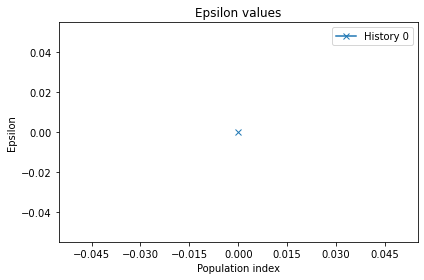

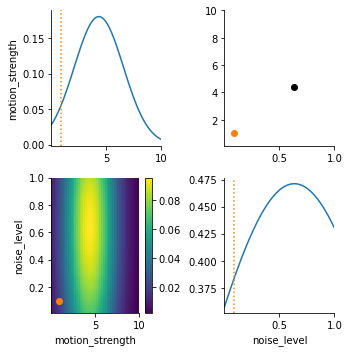

In [16]:
db_path = "sqlite:///RG_MSD1.db"
h = pyabc.History(db_path)
limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=0)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

## Now the juicy part: loop over SSs:
After testing, the Heterogeneity Ratio was discarded because its efficienty was not nearly as good as the rest and it was consuming too much computational time. 

In [18]:
# Extensions of SS functions:
#ss_list = ['MSD', 'VAC', 'DR', 'RG', 'HR']
ss_list = ['VAC', 'RG', 'MSD', 'DR']

for el1 in ss_list:
    measured_list = []
    for el2 in ss_list:
        measured_list.append(el2)
        if (el1 != el2) and (el1 not in measured_list):
            #print(el1,el2)
            functions_names = []
            d = el1 + '_' + el2
            functions_names.append('data_' + el1 + '_' + el2)
            #data = ['data%s' % os.join.el1]
            dist1 = globals()['distance%s' % el1]
            dist2 = globals()['distance%s' % el2]
            distances = [dist1,dist2]
            print('Working with ',d)
            data = fmc_mot_pipeline("Demo_CellMotility.xml", t_init=1, time_interval=100, populations=6, dist_functions=distances, dist_functions_names=d)
            globals()['data_' + el1 + '_'+ el2] = data
        elif (el1 == el2):
            d = el1 + '_' + el2
            dist1 = globals()['distance%s' % el1]
            dist2 = globals()['distance%s' % el2]
            distances = [dist1,dist2]
            print('Working with ', str(dist1))
            data = fmc_mot_pipeline("Demo_CellMotility.xml", t_init=1, time_interval=100, populations=6, dist_functions=distances[0], dist_functions_names=d)
            globals()['data_' + el1 + '_'+ el2] = data            


INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 11:45:41.562360, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Working with  <function distanceVAC at 0x7fe53fb2b3a0>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.46039643249365736
INFO:ABC:t: 0, eps: 0.46039643249365736.
INFO:ABC:Acceptance rate: 100 / 166 = 6.0241e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.2054271355693765.
INFO:ABC:Acceptance rate: 100 / 285 = 3.5088e-01, ESS=8.3294e+01.
INFO:ABC:t: 2, eps: 0.1209627000151214.
INFO:ABC:Acceptance rate: 100 / 309 = 3.2362e-01, ESS=4.6208e+01.
INFO:ABC:t: 3, eps: 0.09468883510942727.
INFO:ABC:Acceptance rate: 100 / 798 = 1.2531e-01, ESS=8.9065e+01.
INFO:ABC:t: 4, eps: 0.07407028973689109.
INFO:ABC:Acceptance rate: 100 / 1428 = 7.0028e-02, ESS=9.1956e+01.
INFO:ABC:t: 5, eps: 0.06136377203077132.
INFO:ABC:Acceptance rate: 100 / 2189 = 4.5683e-02, ESS=1.7661e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 11:45:41.562360, end_time=2021-01-12 12:59:33.060050)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 12:59:33.139478, end_time=None)>


Working with  RG_VAC
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 1.055062439148108
INFO:ABC:t: 0, eps: 1.055062439148108.
INFO:ABC:Acceptance rate: 100 / 179 = 5.5866e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.8485511474362767.
INFO:ABC:Acceptance rate: 100 / 250 = 4.0000e-01, ESS=8.7128e+01.
INFO:ABC:t: 2, eps: 0.6855702296797526.
INFO:ABC:Acceptance rate: 100 / 330 = 3.0303e-01, ESS=7.7301e+01.
INFO:ABC:t: 3, eps: 0.5541568027916732.
INFO:ABC:Acceptance rate: 100 / 457 = 2.1882e-01, ESS=8.3794e+01.
INFO:ABC:t: 4, eps: 0.43193446897430743.
INFO:ABC:Acceptance rate: 100 / 520 = 1.9231e-01, ESS=7.6302e+01.
INFO:ABC:t: 5, eps: 0.35250185189027133.
INFO:ABC:Acceptance rate: 100 / 466 = 2.1459e-01, ESS=8.6412e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 12:59:33.139478, end_time=2021-01-12 13:30:38.255628)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 13:30:38.344185, end_time=None)>
INFO:AB

Working with  <function distanceRG at 0x7fe53fb2b4c0>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.5754252654852396
INFO:ABC:t: 0, eps: 0.5754252654852396.
INFO:ABC:Acceptance rate: 100 / 216 = 4.6296e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.37900995911649543.
INFO:ABC:Acceptance rate: 100 / 249 = 4.0161e-01, ESS=8.2315e+01.
INFO:ABC:t: 2, eps: 0.2530859744731256.
INFO:ABC:Acceptance rate: 100 / 475 = 2.1053e-01, ESS=6.9859e+01.
INFO:ABC:t: 3, eps: 0.2018726421491916.
INFO:ABC:Acceptance rate: 100 / 811 = 1.2330e-01, ESS=8.6726e+01.
INFO:ABC:t: 4, eps: 0.15657418840839116.
INFO:ABC:Acceptance rate: 100 / 1340 = 7.4627e-02, ESS=7.2610e+01.
INFO:ABC:t: 5, eps: 0.12641034844899396.
INFO:ABC:Acceptance rate: 100 / 2048 = 4.8828e-02, ESS=6.0511e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 13:30:38.344185, end_time=2021-01-12 14:41:50.823029)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 14:41:50.972673, end_time=None)>
IN

Working with  MSD_VAC
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 1.011161081833951
INFO:ABC:t: 0, eps: 1.011161081833951.
INFO:ABC:Acceptance rate: 100 / 206 = 4.8544e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.8451839039367588.
INFO:ABC:Acceptance rate: 100 / 305 = 3.2787e-01, ESS=7.1936e+01.
INFO:ABC:t: 2, eps: 0.6862576712980013.
INFO:ABC:Acceptance rate: 100 / 481 = 2.0790e-01, ESS=8.9387e+01.
INFO:ABC:t: 3, eps: 0.5494719930107457.
INFO:ABC:Acceptance rate: 100 / 592 = 1.6892e-01, ESS=7.3078e+01.
INFO:ABC:t: 4, eps: 0.4420643032185497.
INFO:ABC:Acceptance rate: 100 / 670 = 1.4925e-01, ESS=8.6096e+01.
INFO:ABC:t: 5, eps: 0.33409610746207447.
INFO:ABC:Acceptance rate: 100 / 759 = 1.3175e-01, ESS=4.1466e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 14:41:50.972673, end_time=2021-01-12 15:29:11.592285)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 15:29:11.645946, end_time=None)>
INFO:ABC

Working with  MSD_RG
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 1.3607756476535102
INFO:ABC:t: 0, eps: 1.3607756476535102.
INFO:ABC:Acceptance rate: 100 / 225 = 4.4444e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 1.0475724644812296.
INFO:ABC:Acceptance rate: 100 / 271 = 3.6900e-01, ESS=8.3907e+01.
INFO:ABC:t: 2, eps: 0.8164467731476269.
INFO:ABC:Acceptance rate: 100 / 391 = 2.5575e-01, ESS=8.5666e+01.
INFO:ABC:t: 3, eps: 0.5963047980911801.
INFO:ABC:Acceptance rate: 100 / 539 = 1.8553e-01, ESS=7.9334e+01.
INFO:ABC:t: 4, eps: 0.4544016074259722.
INFO:ABC:Acceptance rate: 100 / 1269 = 7.8802e-02, ESS=9.1694e+01.
INFO:ABC:t: 5, eps: 0.348250070486194.
INFO:ABC:Acceptance rate: 100 / 1648 = 6.0680e-02, ESS=6.5892e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 15:29:11.645946, end_time=2021-01-12 16:35:01.106722)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 16:35:01.171029, end_time=None)>
INFO:A

Working with  <function distanceMSD at 0x7fe53fb2b310>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.20591512209143165
INFO:ABC:t: 0, eps: 0.20591512209143165.
INFO:ABC:Acceptance rate: 100 / 191 = 5.2356e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.15351386251654137.
INFO:ABC:Acceptance rate: 100 / 267 = 3.7453e-01, ESS=5.0835e+01.
INFO:ABC:t: 2, eps: 0.11480885656113031.
INFO:ABC:Acceptance rate: 100 / 361 = 2.7701e-01, ESS=8.7596e+01.
INFO:ABC:t: 3, eps: 0.0786083182905185.
INFO:ABC:Acceptance rate: 100 / 671 = 1.4903e-01, ESS=9.1441e+01.
INFO:ABC:t: 4, eps: 0.05492931142121323.
INFO:ABC:Acceptance rate: 100 / 1252 = 7.9872e-02, ESS=7.2007e+01.
INFO:ABC:t: 5, eps: 0.03896060863651063.
INFO:ABC:Acceptance rate: 100 / 2805 = 3.5651e-02, ESS=8.1408e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 16:35:01.171029, end_time=2021-01-12 17:55:24.780560)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 17:55:24.830924, end_time=None)>

Working with  DR_VAC
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.8004496943224138
INFO:ABC:t: 0, eps: 0.8004496943224138.
INFO:ABC:Acceptance rate: 100 / 183 = 5.4645e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.5305316699908733.
INFO:ABC:Acceptance rate: 100 / 297 = 3.3670e-01, ESS=8.9686e+01.
INFO:ABC:t: 2, eps: 0.423432688024408.
INFO:ABC:Acceptance rate: 100 / 367 = 2.7248e-01, ESS=8.8773e+01.
INFO:ABC:t: 3, eps: 0.339086626242354.
INFO:ABC:Acceptance rate: 100 / 575 = 1.7391e-01, ESS=9.0107e+01.
INFO:ABC:t: 4, eps: 0.259602922469403.
INFO:ABC:Acceptance rate: 100 / 1035 = 9.6618e-02, ESS=8.3927e+01.
INFO:ABC:t: 5, eps: 0.2287054386726482.
INFO:ABC:Acceptance rate: 100 / 1433 = 6.9784e-02, ESS=6.3464e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 17:55:24.830924, end_time=2021-01-12 18:48:04.603221)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 18:48:04.654160, end_time=None)>
INFO:ABC

Working with  DR_RG
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 1.1239046278529843
INFO:ABC:t: 0, eps: 1.1239046278529843.
INFO:ABC:Acceptance rate: 100 / 207 = 4.8309e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7955862190173035.
INFO:ABC:Acceptance rate: 100 / 417 = 2.3981e-01, ESS=9.3252e+01.
INFO:ABC:t: 2, eps: 0.6010725641056054.
INFO:ABC:Acceptance rate: 100 / 686 = 1.4577e-01, ESS=7.0782e+01.
INFO:ABC:t: 3, eps: 0.46271303517524975.
INFO:ABC:Acceptance rate: 100 / 975 = 1.0256e-01, ESS=6.2714e+01.
INFO:ABC:t: 4, eps: 0.39623991380078954.
INFO:ABC:Acceptance rate: 100 / 1905 = 5.2493e-02, ESS=8.3989e+01.
INFO:ABC:t: 5, eps: 0.3106306656917354.
INFO:ABC:Acceptance rate: 100 / 2960 = 3.3784e-02, ESS=5.5015e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 18:48:04.654160, end_time=2021-01-12 20:27:56.405472)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 20:27:56.465645, end_time=None)>
INF

Working with  DR_MSD
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.9701489329102755
INFO:ABC:t: 0, eps: 0.9701489329102755.
INFO:ABC:Acceptance rate: 100 / 197 = 5.0761e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7171655502096654.
INFO:ABC:Acceptance rate: 100 / 337 = 2.9674e-01, ESS=9.0914e+01.
INFO:ABC:t: 2, eps: 0.5234542522629889.
INFO:ABC:Acceptance rate: 100 / 504 = 1.9841e-01, ESS=8.5483e+01.
INFO:ABC:t: 3, eps: 0.39245326249003487.
INFO:ABC:Acceptance rate: 100 / 993 = 1.0070e-01, ESS=8.3420e+01.
INFO:ABC:t: 4, eps: 0.3072575353493259.
INFO:ABC:Acceptance rate: 100 / 1694 = 5.9032e-02, ESS=4.2791e+01.
INFO:ABC:t: 5, eps: 0.2676750053647485.
INFO:ABC:Acceptance rate: 100 / 3607 = 2.7724e-02, ESS=5.1007e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 20:27:56.465645, end_time=2021-01-12 22:09:27.156701)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-12 22:09:27.207865, end_time=None)>
INFO

Working with  <function distanceDR at 0x7fe53fb2b430>
MorpheusModel {
	name      : Demo_CellMotility.xml
}


INFO:Epsilon:initial epsilon is 0.3508789052019136
INFO:ABC:t: 0, eps: 0.3508789052019136.
INFO:ABC:Acceptance rate: 100 / 189 = 5.2910e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.2056775709259678.
INFO:ABC:Acceptance rate: 100 / 438 = 2.2831e-01, ESS=8.9995e+01.
INFO:ABC:t: 2, eps: 0.1480976237062622.
INFO:ABC:Acceptance rate: 100 / 889 = 1.1249e-01, ESS=9.1313e+01.
INFO:ABC:t: 3, eps: 0.11620229086550954.
INFO:ABC:Acceptance rate: 100 / 1659 = 6.0277e-02, ESS=9.1349e+01.
INFO:ABC:t: 4, eps: 0.0886441491141654.
INFO:ABC:Acceptance rate: 100 / 4289 = 2.3315e-02, ESS=8.6044e+01.
INFO:ABC:t: 5, eps: 0.0694061509795279.
INFO:ABC:Acceptance rate: 100 / 9664 = 1.0348e-02, ESS=8.6112e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-12 22:09:27.207865, end_time=2021-01-13 01:53:45.191752)>


## Run with t = 10%

In [31]:
# Test it works properly:
#fmc_mot_pipeline("Demo_CellMotility10.xml", t_init=10, time_interval=10, populations=1, dist_functions=[distanceMSD, distanceRG], dist_functions_names='RG_MSD', percentage='10')

ss_list = ['VAC', 'RG', 'MSD', 'DR']

for el1 in ss_list:
    measured_list = []
    for el2 in ss_list:
        measured_list.append(el2)
        if (el1 != el2) and (el1 not in measured_list):
            #print(el1,el2)
            functions_names = []
            d = el1 + '_' + el2
            functions_names.append('data_' + el1 + '_' + el2)
            #data = ['data%s' % os.join.el1]
            dist1 = globals()['distance%s' % el1]
            dist2 = globals()['distance%s' % el2]
            distances = [dist1,dist2]
            print('Working with ',d)
            data = fmc_mot_pipeline("Demo_CellMotility10.xml", t_init=10, time_interval=10, populations=6, dist_functions=distances, dist_functions_names=d, percentage='10')
            globals()['data_' + el1 + '_'+ el2] = data
        elif (el1 == el2):
            d = el1 + '_' + el2
            dist1 = globals()['distance%s' % el1]
            dist2 = globals()['distance%s' % el2]
            distances = [dist1,dist2]
            print('Working with ', str(dist1))
            data = fmc_mot_pipeline("Demo_CellMotility10.xml", t_init=10, time_interval=10, populations=6, dist_functions=distances[0], dist_functions_names=d, percentage='10')
            globals()['data_' + el1 + '_'+ el2] = data            



INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=2, start_time=2021-01-13 10:51:39.574524, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Working with  <function distanceVAC at 0x7fe540059af0>
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 0.24426699184971126
INFO:ABC:t: 0, eps: 0.24426699184971126.
INFO:ABC:Acceptance rate: 100 / 233 = 4.2918e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.17499755044966778.
INFO:ABC:Acceptance rate: 100 / 257 = 3.8911e-01, ESS=8.8825e+01.
INFO:ABC:t: 2, eps: 0.13302503205596625.
INFO:ABC:Acceptance rate: 100 / 260 = 3.8462e-01, ESS=6.9568e+01.
INFO:ABC:t: 3, eps: 0.11376068204624622.
INFO:ABC:Acceptance rate: 100 / 469 = 2.1322e-01, ESS=6.2896e+01.
INFO:ABC:t: 4, eps: 0.10031790789847994.
INFO:ABC:Acceptance rate: 100 / 513 = 1.9493e-01, ESS=6.6186e+01.
INFO:ABC:t: 5, eps: 0.08562895110781506.
INFO:ABC:Acceptance rate: 100 / 660 = 1.5152e-01, ESS=8.4995e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=2, start_time=2021-01-13 10:51:39.574524, end_time=2021-01-13 11:29:46.318318)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 11:29:46.376862, end_time=None)>


Working with  RG_VAC
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 0.8938781280758488
INFO:ABC:t: 0, eps: 0.8938781280758488.
INFO:ABC:Acceptance rate: 100 / 226 = 4.4248e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7382510149406947.
INFO:ABC:Acceptance rate: 100 / 319 = 3.1348e-01, ESS=9.4572e+01.
INFO:ABC:t: 2, eps: 0.6183423936937901.
INFO:ABC:Acceptance rate: 100 / 279 = 3.5842e-01, ESS=5.4717e+01.
INFO:ABC:t: 3, eps: 0.5125675798756942.
INFO:ABC:Acceptance rate: 100 / 425 = 2.3529e-01, ESS=8.6044e+01.
INFO:ABC:t: 4, eps: 0.4060165987761464.
INFO:ABC:Acceptance rate: 100 / 488 = 2.0492e-01, ESS=3.2749e+01.
INFO:ABC:t: 5, eps: 0.3252329760792724.
INFO:ABC:Acceptance rate: 100 / 580 = 1.7241e-01, ESS=3.2698e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 11:29:46.376862, end_time=2021-01-13 12:05:29.869429)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 12:05:29.935965, end_time=None)>
INFO:AB

Working with  <function distanceRG at 0x7fe540059280>
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 0.4559920332448719
INFO:ABC:t: 0, eps: 0.4559920332448719.
INFO:ABC:Acceptance rate: 100 / 260 = 3.8462e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3150452319096866.
INFO:ABC:Acceptance rate: 100 / 244 = 4.0984e-01, ESS=9.1840e+01.
INFO:ABC:t: 2, eps: 0.24744844813554884.
INFO:ABC:Acceptance rate: 100 / 256 = 3.9062e-01, ESS=3.5150e+01.
INFO:ABC:t: 3, eps: 0.19800853963116333.
INFO:ABC:Acceptance rate: 100 / 748 = 1.3369e-01, ESS=8.9614e+01.
INFO:ABC:t: 4, eps: 0.15372327823241938.
INFO:ABC:Acceptance rate: 100 / 948 = 1.0549e-01, ESS=6.2629e+01.
INFO:ABC:t: 5, eps: 0.12652355472635757.
INFO:ABC:Acceptance rate: 100 / 1586 = 6.3052e-02, ESS=7.4273e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 12:05:29.935965, end_time=2021-01-13 13:03:29.775048)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 13:03:29.852345, end_time=None)>
IN

Working with  MSD_VAC
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 0.9636768484983518
INFO:ABC:t: 0, eps: 0.9636768484983518.
INFO:ABC:Acceptance rate: 100 / 162 = 6.1728e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.8045557106433412.
INFO:ABC:Acceptance rate: 100 / 274 = 3.6496e-01, ESS=6.5279e+01.
INFO:ABC:t: 2, eps: 0.7021385647671893.
INFO:ABC:Acceptance rate: 100 / 503 = 1.9881e-01, ESS=8.1715e+01.
INFO:ABC:t: 3, eps: 0.5580078625912805.
INFO:ABC:Acceptance rate: 100 / 574 = 1.7422e-01, ESS=8.4005e+01.
INFO:ABC:t: 4, eps: 0.4394326792179517.
INFO:ABC:Acceptance rate: 100 / 807 = 1.2392e-01, ESS=8.6523e+01.
INFO:ABC:t: 5, eps: 0.34414829980703393.
INFO:ABC:Acceptance rate: 100 / 1048 = 9.5420e-02, ESS=6.9474e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 13:03:29.852345, end_time=2021-01-13 13:51:47.529119)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 13:51:47.616452, end_time=None)>
INFO:

Working with  MSD_RG
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 1.039067968827793
INFO:ABC:t: 0, eps: 1.039067968827793.
INFO:ABC:Acceptance rate: 100 / 226 = 4.4248e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7023463268817846.
INFO:ABC:Acceptance rate: 100 / 294 = 3.4014e-01, ESS=8.2242e+01.
INFO:ABC:t: 2, eps: 0.5386195531935217.
INFO:ABC:Acceptance rate: 100 / 490 = 2.0408e-01, ESS=7.6470e+01.
INFO:ABC:t: 3, eps: 0.41981176740067055.
INFO:ABC:Acceptance rate: 100 / 640 = 1.5625e-01, ESS=8.3711e+01.
INFO:ABC:t: 4, eps: 0.31852009119701347.
INFO:ABC:Acceptance rate: 100 / 1114 = 8.9767e-02, ESS=8.1042e+01.
INFO:ABC:t: 5, eps: 0.2505999721194094.
INFO:ABC:Acceptance rate: 100 / 2297 = 4.3535e-02, ESS=8.4158e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 13:51:47.616452, end_time=2021-01-13 15:02:00.141656)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 15:02:00.195252, end_time=None)>
INFO:

Working with  <function distanceMSD at 0x7fe540370e50>
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 0.4900307130699406
INFO:ABC:t: 0, eps: 0.4900307130699406.
INFO:ABC:Acceptance rate: 100 / 224 = 4.4643e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3515269948527513.
INFO:ABC:Acceptance rate: 100 / 349 = 2.8653e-01, ESS=8.9021e+01.
INFO:ABC:t: 2, eps: 0.2601302758754754.
INFO:ABC:Acceptance rate: 100 / 430 = 2.3256e-01, ESS=9.0885e+01.
INFO:ABC:t: 3, eps: 0.18158212025751072.
INFO:ABC:Acceptance rate: 100 / 636 = 1.5723e-01, ESS=8.4098e+01.
INFO:ABC:t: 4, eps: 0.12054571376803952.
INFO:ABC:Acceptance rate: 100 / 1708 = 5.8548e-02, ESS=4.2569e+01.
INFO:ABC:t: 5, eps: 0.0897641271303162.
INFO:ABC:Acceptance rate: 100 / 3761 = 2.6589e-02, ESS=7.9753e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 15:02:00.195252, end_time=2021-01-13 16:47:02.290114)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 16:47:02.344395, end_time=None)>
INF

Working with  DR_VAC
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 1.2799563857735725
INFO:ABC:t: 0, eps: 1.2799563857735725.
INFO:ABC:Acceptance rate: 100 / 160 = 6.2500e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.9707815507362703.
INFO:ABC:Acceptance rate: 100 / 330 = 3.0303e-01, ESS=9.0346e+01.
INFO:ABC:t: 2, eps: 0.6804776673332297.
INFO:ABC:Acceptance rate: 100 / 339 = 2.9499e-01, ESS=9.1441e+01.
INFO:ABC:t: 3, eps: 0.4429532558934695.
INFO:ABC:Acceptance rate: 100 / 352 = 2.8409e-01, ESS=8.3332e+01.
INFO:ABC:t: 4, eps: 0.33846842245658826.
INFO:ABC:Acceptance rate: 100 / 454 = 2.2026e-01, ESS=8.1795e+01.
INFO:ABC:t: 5, eps: 0.28047380230503244.
INFO:ABC:Acceptance rate: 100 / 823 = 1.2151e-01, ESS=1.7111e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 16:47:02.344395, end_time=2021-01-13 17:23:37.000317)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 17:23:37.051860, end_time=None)>
INFO:

Working with  DR_RG
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 1.1897690157909566
INFO:ABC:t: 0, eps: 1.1897690157909566.
INFO:ABC:Acceptance rate: 100 / 226 = 4.4248e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.8768635827889238.
INFO:ABC:Acceptance rate: 100 / 291 = 3.4364e-01, ESS=9.5771e+01.
INFO:ABC:t: 2, eps: 0.6575748805302708.
INFO:ABC:Acceptance rate: 100 / 408 = 2.4510e-01, ESS=6.0732e+01.
INFO:ABC:t: 3, eps: 0.488441326786388.
INFO:ABC:Acceptance rate: 100 / 744 = 1.3441e-01, ESS=8.9763e+01.
INFO:ABC:t: 4, eps: 0.41180075830064045.
INFO:ABC:Acceptance rate: 100 / 522 = 1.9157e-01, ESS=7.7590e+01.
INFO:ABC:t: 5, eps: 0.34042141181699037.
INFO:ABC:Acceptance rate: 100 / 534 = 1.8727e-01, ESS=5.8195e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 17:23:37.051860, end_time=2021-01-13 18:01:26.706615)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 18:01:26.762366, end_time=None)>
INFO:A

Working with  DR_MSD
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 0.9526693419086585
INFO:ABC:t: 0, eps: 0.9526693419086585.
INFO:ABC:Acceptance rate: 100 / 222 = 4.5045e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7769205706593939.
INFO:ABC:Acceptance rate: 100 / 244 = 4.0984e-01, ESS=8.5516e+01.
INFO:ABC:t: 2, eps: 0.5528950470396092.
INFO:ABC:Acceptance rate: 100 / 346 = 2.8902e-01, ESS=8.4312e+01.
INFO:ABC:t: 3, eps: 0.40154944647361357.
INFO:ABC:Acceptance rate: 100 / 387 = 2.5840e-01, ESS=5.5435e+01.
INFO:ABC:t: 4, eps: 0.28394273476345955.
INFO:ABC:Acceptance rate: 100 / 776 = 1.2887e-01, ESS=3.5338e+01.
INFO:ABC:t: 5, eps: 0.24551086902336813.
INFO:ABC:Acceptance rate: 100 / 1047 = 9.5511e-02, ESS=4.6048e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 18:01:26.762366, end_time=2021-01-13 18:43:32.339916)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 18:43:32.394647, end_time=None)>
INF

Working with  <function distanceDR at 0x7fe53fb2b3a0>
MorpheusModel {
	name      : Demo_CellMotility10.xml
}


INFO:Epsilon:initial epsilon is 0.7361502262346405
INFO:ABC:t: 0, eps: 0.7361502262346405.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.46347173432940086.
INFO:ABC:Acceptance rate: 100 / 237 = 4.2194e-01, ESS=8.6445e+01.
INFO:ABC:t: 2, eps: 0.2610954919061373.
INFO:ABC:Acceptance rate: 100 / 301 = 3.3223e-01, ESS=9.4424e+01.
INFO:ABC:t: 3, eps: 0.16836796076270893.
INFO:ABC:Acceptance rate: 100 / 465 = 2.1505e-01, ESS=8.6576e+01.
INFO:ABC:t: 4, eps: 0.1255929788795505.
INFO:ABC:Acceptance rate: 100 / 674 = 1.4837e-01, ESS=7.1815e+01.
INFO:ABC:t: 5, eps: 0.10186621998243871.
INFO:ABC:Acceptance rate: 100 / 1060 = 9.4340e-02, ESS=7.9440e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 18:43:32.394647, end_time=2021-01-13 19:24:33.093249)>


## With 100%

In [48]:
ss_list = ['VAC', 'RG', 'MSD', 'DR']

for el1 in ss_list:
    measured_list = []
    for el2 in ss_list:
        measured_list.append(el2)
        if (el1 != el2) and (el1 not in measured_list):
            #print(el1,el2)
            functions_names = []
            d = el1 + '_' + el2
            functions_names.append('data_' + el1 + '_' + el2)
            #data = ['data%s' % os.join.el1]
            dist1 = globals()['distance%s' % el1]
            dist2 = globals()['distance%s' % el2]
            distances = [dist1,dist2]
            print('Working with ',d)
            data = fmc_mot_pipeline("Demo_CellMotility100.xml", t_init=100, time_interval=1, populations=6, dist_functions=distances, dist_functions_names=d, percentage='100')
            globals()['data_' + el1 + '_'+ el2] = data
        elif (el1 == el2):
            d = el1 + '_' + el2
            dist1 = globals()['distance%s' % el1]
            dist2 = globals()['distance%s' % el2]
            distances = [dist1,dist2]
            print('Working with ', str(dist1))
            data = fmc_mot_pipeline("Demo_CellMotility100.xml", t_init=100, time_interval=1, populations=6, dist_functions=distances[0], dist_functions_names=d, percentage='100')
            globals()['data_' + el1 + '_'+ el2] = data 

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 20:27:14.007134, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Working with  <function distanceVAC at 0x7fe540370e50>
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 0.27839191822953374
INFO:ABC:t: 0, eps: 0.27839191822953374.
INFO:ABC:Acceptance rate: 100 / 162 = 6.1728e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.19151404264579805.
INFO:ABC:Acceptance rate: 100 / 235 = 4.2553e-01, ESS=7.1217e+01.
INFO:ABC:t: 2, eps: 0.15644838444155473.
INFO:ABC:Acceptance rate: 100 / 274 = 3.6496e-01, ESS=6.2909e+01.
INFO:ABC:t: 3, eps: 0.13714280363440776.
INFO:ABC:Acceptance rate: 100 / 453 = 2.2075e-01, ESS=4.6980e+01.
INFO:ABC:t: 4, eps: 0.12464864082576742.
INFO:ABC:Acceptance rate: 100 / 984 = 1.0163e-01, ESS=9.5448e+01.
INFO:ABC:t: 5, eps: 0.10546304367405974.
INFO:ABC:Acceptance rate: 100 / 551 = 1.8149e-01, ESS=9.0708e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 20:27:14.007134, end_time=2021-01-13 21:19:58.635624)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 21:19:58.687549, end_time=None)>


Working with  RG_VAC
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 0.7785277530664145
INFO:ABC:t: 0, eps: 0.7785277530664145.
INFO:ABC:Acceptance rate: 100 / 202 = 4.9505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.601586178664664.
INFO:ABC:Acceptance rate: 100 / 278 = 3.5971e-01, ESS=8.0406e+01.
INFO:ABC:t: 2, eps: 0.4893871183208841.
INFO:ABC:Acceptance rate: 100 / 407 = 2.4570e-01, ESS=4.2766e+01.
INFO:ABC:t: 3, eps: 0.4019266403860096.
INFO:ABC:Acceptance rate: 100 / 656 = 1.5244e-01, ESS=6.0046e+01.
INFO:ABC:t: 4, eps: 0.3393780798506956.
INFO:ABC:Acceptance rate: 100 / 750 = 1.3333e-01, ESS=9.1689e+01.
INFO:ABC:t: 5, eps: 0.27289006827865403.
INFO:ABC:Acceptance rate: 100 / 494 = 2.0243e-01, ESS=6.3638e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 21:19:58.687549, end_time=2021-01-13 22:10:19.270858)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 22:10:19.332136, end_time=None)>
INFO:AB

Working with  <function distanceRG at 0x7fe540599550>
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 0.4424423049730778
INFO:ABC:t: 0, eps: 0.4424423049730778.
INFO:ABC:Acceptance rate: 100 / 261 = 3.8314e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.29764154589352754.
INFO:ABC:Acceptance rate: 100 / 338 = 2.9586e-01, ESS=8.2910e+01.
INFO:ABC:t: 2, eps: 0.21180375599541573.
INFO:ABC:Acceptance rate: 100 / 401 = 2.4938e-01, ESS=8.1618e+01.
INFO:ABC:t: 3, eps: 0.16196359682867506.
INFO:ABC:Acceptance rate: 100 / 682 = 1.4663e-01, ESS=6.7939e+01.
INFO:ABC:t: 4, eps: 0.13130245285842884.
INFO:ABC:Acceptance rate: 100 / 1473 = 6.7889e-02, ESS=8.2104e+01.
INFO:ABC:t: 5, eps: 0.10694051883252226.
INFO:ABC:Acceptance rate: 100 / 1712 = 5.8411e-02, ESS=8.3131e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 22:10:19.332136, end_time=2021-01-13 23:32:53.157533)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-13 23:32:53.273151, end_time=None)>


Working with  MSD_VAC
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 0.6964339798182028
INFO:ABC:t: 0, eps: 0.6964339798182028.
INFO:ABC:Acceptance rate: 100 / 230 = 4.3478e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.6306138799811645.
INFO:ABC:Acceptance rate: 100 / 387 = 2.5840e-01, ESS=7.7093e+01.
INFO:ABC:t: 2, eps: 0.5094245090370325.
INFO:ABC:Acceptance rate: 100 / 639 = 1.5649e-01, ESS=8.6221e+01.
INFO:ABC:t: 3, eps: 0.4045177886228727.
INFO:ABC:Acceptance rate: 100 / 619 = 1.6155e-01, ESS=7.5577e+01.
INFO:ABC:t: 4, eps: 0.29894672081530654.
INFO:ABC:Acceptance rate: 100 / 942 = 1.0616e-01, ESS=8.9770e+01.
INFO:ABC:t: 5, eps: 0.2368275878748573.
INFO:ABC:Acceptance rate: 100 / 1210 = 8.2645e-02, ESS=8.0990e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-13 23:32:53.273151, end_time=2021-01-14 00:28:18.038531)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-14 00:28:18.092216, end_time=None)>
INFO:

Working with  MSD_RG
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 1.0515625415106888
INFO:ABC:t: 0, eps: 1.0515625415106888.
INFO:ABC:Acceptance rate: 100 / 179 = 5.5866e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7316776930849198.
INFO:ABC:Acceptance rate: 100 / 224 = 4.4643e-01, ESS=8.8168e+01.
INFO:ABC:t: 2, eps: 0.5191046550385462.
INFO:ABC:Acceptance rate: 100 / 424 = 2.3585e-01, ESS=8.8397e+01.
INFO:ABC:t: 3, eps: 0.4103083663324618.
INFO:ABC:Acceptance rate: 100 / 663 = 1.5083e-01, ESS=6.5312e+01.
INFO:ABC:t: 4, eps: 0.34686385174742396.
INFO:ABC:Acceptance rate: 100 / 882 = 1.1338e-01, ESS=7.7995e+01.
INFO:ABC:t: 5, eps: 0.276070808681482.
INFO:ABC:Acceptance rate: 100 / 1571 = 6.3654e-02, ESS=4.8043e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-14 00:28:18.092216, end_time=2021-01-14 01:29:18.653381)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-14 01:29:18.706384, end_time=None)>
INFO:A

Working with  <function distanceMSD at 0x7fe540505940>
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 0.5858493044056188
INFO:ABC:t: 0, eps: 0.5858493044056188.
INFO:ABC:Acceptance rate: 100 / 190 = 5.2632e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.4211723173999256.
INFO:ABC:Acceptance rate: 100 / 325 = 3.0769e-01, ESS=8.4071e+01.
INFO:ABC:t: 2, eps: 0.28842371233855846.
INFO:ABC:Acceptance rate: 100 / 485 = 2.0619e-01, ESS=8.9789e+01.
INFO:ABC:t: 3, eps: 0.19910299639863227.
INFO:ABC:Acceptance rate: 100 / 631 = 1.5848e-01, ESS=7.1824e+01.
INFO:ABC:t: 4, eps: 0.14186252517020018.
INFO:ABC:Acceptance rate: 100 / 1594 = 6.2735e-02, ESS=8.9347e+01.
INFO:ABC:t: 5, eps: 0.10408732533921287.
INFO:ABC:Acceptance rate: 100 / 2895 = 3.4542e-02, ESS=6.6541e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-14 01:29:18.706384, end_time=2021-01-14 02:54:21.404624)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-14 02:54:21.455869, end_time=None)>
I

Working with  DR_VAC
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 1.1938729228937164
INFO:ABC:t: 0, eps: 1.1938729228937164.
INFO:ABC:Acceptance rate: 100 / 204 = 4.9020e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 1.051694949638314.
INFO:ABC:Acceptance rate: 100 / 216 = 4.6296e-01, ESS=6.8206e+01.
INFO:ABC:t: 2, eps: 0.8777480495720357.
INFO:ABC:Acceptance rate: 100 / 378 = 2.6455e-01, ESS=8.9942e+01.
INFO:ABC:t: 3, eps: 0.5784092770099207.
INFO:ABC:Acceptance rate: 100 / 295 = 3.3898e-01, ESS=9.0717e+01.
INFO:ABC:t: 4, eps: 0.35634936608409384.
INFO:ABC:Acceptance rate: 100 / 396 = 2.5253e-01, ESS=9.4971e+01.
INFO:ABC:t: 5, eps: 0.3021000108292845.
INFO:ABC:Acceptance rate: 100 / 515 = 1.9417e-01, ESS=8.4330e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-14 02:54:21.455869, end_time=2021-01-14 03:23:20.660576)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-14 03:23:20.715818, end_time=None)>
INFO:AB

Working with  DR_RG
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 1.281241454695579
INFO:ABC:t: 0, eps: 1.281241454695579.
INFO:ABC:Acceptance rate: 100 / 196 = 5.1020e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.8502854023496407.
INFO:ABC:Acceptance rate: 100 / 278 = 3.5971e-01, ESS=8.1229e+01.
INFO:ABC:t: 2, eps: 0.7265603765057976.
INFO:ABC:Acceptance rate: 100 / 347 = 2.8818e-01, ESS=8.3166e+01.
INFO:ABC:t: 3, eps: 0.5953201363549154.
INFO:ABC:Acceptance rate: 100 / 362 = 2.7624e-01, ESS=8.4709e+01.
INFO:ABC:t: 4, eps: 0.43866169321763904.
INFO:ABC:Acceptance rate: 100 / 496 = 2.0161e-01, ESS=6.6058e+01.
INFO:ABC:t: 5, eps: 0.33849187632329003.
INFO:ABC:Acceptance rate: 100 / 655 = 1.5267e-01, ESS=7.4653e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-14 03:23:20.715818, end_time=2021-01-14 03:59:31.285560)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-14 03:59:31.337474, end_time=None)>
INFO:AB

Working with  DR_MSD
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 1.0530636624847707
INFO:ABC:t: 0, eps: 1.0530636624847707.
INFO:ABC:Acceptance rate: 100 / 194 = 5.1546e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7527189509325944.
INFO:ABC:Acceptance rate: 100 / 282 = 3.5461e-01, ESS=7.9583e+01.
INFO:ABC:t: 2, eps: 0.5283452212568631.
INFO:ABC:Acceptance rate: 100 / 305 = 3.2787e-01, ESS=8.0015e+01.
INFO:ABC:t: 3, eps: 0.3676871954408751.
INFO:ABC:Acceptance rate: 100 / 417 = 2.3981e-01, ESS=8.9185e+01.
INFO:ABC:t: 4, eps: 0.26952968054340926.
INFO:ABC:Acceptance rate: 100 / 497 = 2.0121e-01, ESS=7.1317e+01.
INFO:ABC:t: 5, eps: 0.2206133886429504.
INFO:ABC:Acceptance rate: 100 / 854 = 1.1710e-01, ESS=8.2482e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-14 03:59:31.337474, end_time=2021-01-14 04:35:34.978387)>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-14 04:35:35.035667, end_time=None)>
INFO:A

Working with  <function distanceDR at 0x7fe54073aaf0>
MorpheusModel {
	name      : Demo_CellMotility100.xml
}


INFO:Epsilon:initial epsilon is 0.7905232316807194
INFO:ABC:t: 0, eps: 0.7905232316807194.
INFO:ABC:Acceptance rate: 100 / 193 = 5.1813e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.5191457840537118.
INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=9.1489e+01.
INFO:ABC:t: 2, eps: 0.2221886417678301.
INFO:ABC:Acceptance rate: 100 / 255 = 3.9216e-01, ESS=9.6229e+01.
INFO:ABC:t: 3, eps: 0.14832174077701102.
INFO:ABC:Acceptance rate: 100 / 325 = 3.0769e-01, ESS=8.0727e+01.
INFO:ABC:t: 4, eps: 0.11388383686900262.
INFO:ABC:Acceptance rate: 100 / 475 = 2.1053e-01, ESS=4.2199e+01.
INFO:ABC:t: 5, eps: 0.0856103423732749.
INFO:ABC:Acceptance rate: 100 / 1360 = 7.3529e-02, ESS=9.1155e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-14 04:35:35.035667, end_time=2021-01-14 05:15:04.940986)>


## Quality of fit:

The quality of the fit ($QF$) will be assesed with the following equation:

$$
QF = \frac{(\mathrm{True parameter} - \langle x \rangle)^2}{\sigma^2},
$$

where $\langle x \rangle$ is the posterior's mean and $\sigma^2$ is the variance. Then values closer to zero refer to the best fits.

In [49]:
SSs = ['DR_DR', 'DR_MSD', 'DR_RG', 'DR_VAC', 'MSD_MSD', 'MSD_RG', 'MSD_VAC', 'RG_RG', 'RG_VAC', 'VAC_VAC']
time_per = ['1', '10', '100']


def quality_matrix(SS_list = SSs, times = time_per):
    quality_matrix_1 = np.zeros((len(SS_list), 3))
    #quality_matrix_2 = np.zeros((len(SS_list), 3))
    for idx, el in enumerate(SS_list):
        for idx2, t in enumerate(times):
            db_path = "sqlite:///" + el + t + ".db"
            h = pyabc.History(db_path)
            df, w = h.get_distribution(t=5)
            mean_1 = np.sum(df.motion_strength.values * w)
            mean_2 = np.sum(df.noise_level.values * w)
            var_1 = np.sum(w * (mean_1 - df.motion_strength.values)**2)
            var_2 = np.sum(w * (mean_2 - df.noise_level.values)**2)
            quality_matrix_1[idx, idx2] = (true_pars['motion_strength'] - mean_1)**2 / var_1 + (true_pars['noise_level'] - mean_2)**2 / var_2
    return quality_matrix_1

df1 = quality_matrix()

In [50]:
def HeatMap_function(df, title, transpose = True, colors = 'Greens', dropDuplicates = True):

    if transpose:
        df = df.T
    
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask = np.invert(mask)
        mask[np.triu_indices_from(mask)] = False

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 11))
    ax.set_title(title)
  
    # Add diverging colormap from red to blue
    # cmap = sns.diverging_palette(250, 10, as_cmap=True)
    cmap=plt.get_cmap(colors)
    
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, annot=True, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, annot=True, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('right')

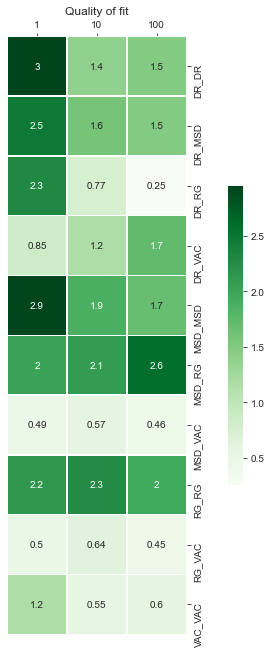

In [51]:
df = pd.DataFrame(df1, columns=time_per, index=SSs)
HeatMap_function(df = df, title = 'Quality of fit', transpose = False,
                 colors = 'Greens', dropDuplicates = False)

Then for this pipeline the best fit would be the one with the DR/RG combination. 

/Users/sebas/opt/anaconda3/lib/python3.8/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


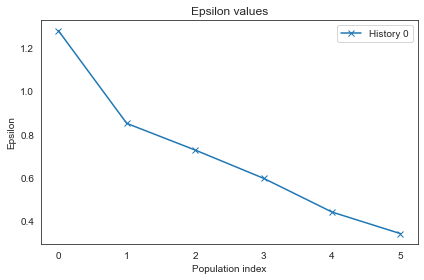

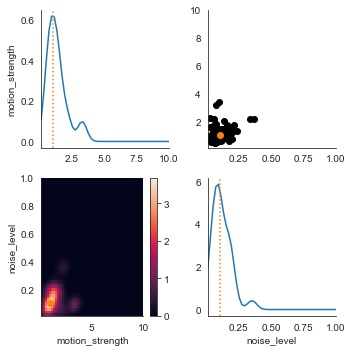

In [52]:
db_path = "sqlite:///" + "DR_RG100.db"
true_pars = {'motion_strength': 1.0, 'noise_level': 0.1}
limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}

h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=5)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

The percentage of time points seems to be less critical in other combinations such as with RG/VAC. The KDE matrix for each combination and time percentage can be seen on the following figure:


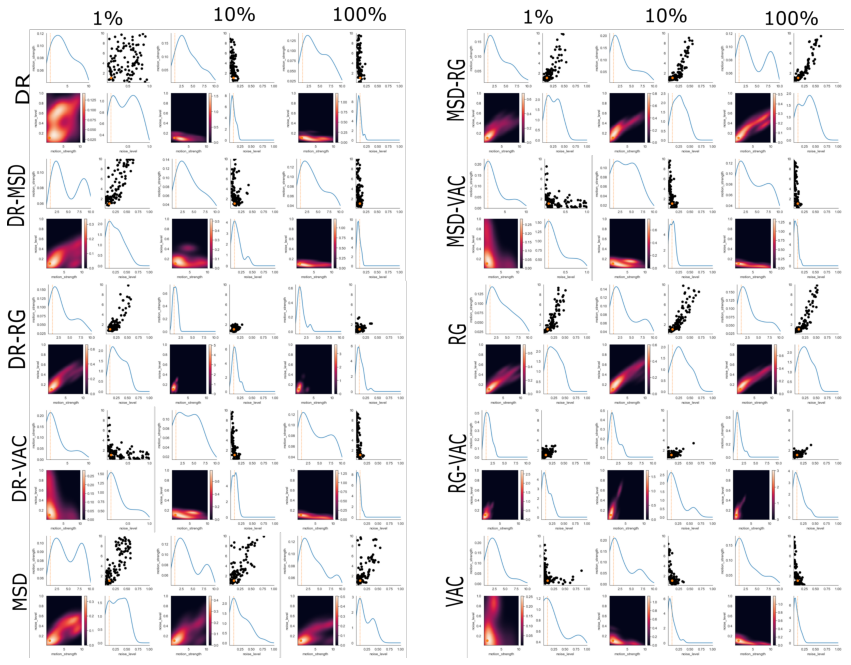

In [57]:
img = plt.imread('SS_summary.png')
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis('off')
plt.show()

A further analysis and discussion will follow as this notebook's goal was to demonstrate how to implement the FitMultiCell pipeline for studies on cell motility. 